In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn as sns
import tqdm
import pymalts as pm
import networkx as nx
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as en
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor
import warnings
import importlib
warnings.filterwarnings("ignore")

path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth_W300.pickle')

iic_burden.keys()

sns.set(font_scale=4,style='whitegrid')

df_pkpd = pd.read_csv('PD_Parameters_result.csv',index_col=0)
df_pkpd = df_pkpd.fillna(df_pkpd.mean())

# Some functions!

In [2]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
        
def policy(Et,a,step):
    t = len(Et)
    X = np.zeros((36//step,1))
    if t>1:
        X[0] = np.nanmean(Et[t-1:t])
    if t>3:
        X[1] = np.nanmean(Et[t-3:t])
    if t>6:
        X[2] = np.nanmean(Et[t-6:t])
        X[5] = np.nanmean(Et[t-3:t]) * np.nanmean(Et[t-6:t])
    if t>12:
        X[3] = np.nanmean(Et[t-12:t])
        X[6] = np.nanmean(Et[t-3:t]) * np.nanmean(Et[t-6:t]) * np.nanmean(Et[t-12:t])
    if t>36:
        X[4] = np.nanmean(Et[t-36:t])
        X[7] = (1-np.nanmean(Et[t-3:t]))*(1-np.nanmean(Et[t-6:t]))*(1-np.nanmean(Et[t-12:t])) * (1-np.nanmean(Et[t-36:t]))
        X[8] = 1
    # for s in range(0,min(t,36),step):
    #     X[s//step] = np.nanmean(Et[t-s:t])
    A = np.matmul(a,X)
    return A

def objective_infer_policy(E,D,a,step):
    a0 = a.reshape((D.shape[1],36//step))
    loss = 0
    T = E.shape[0]
    for t in range(0,T):
        Et = E[:t]
        A = policy(Et,a0,step)
        loss += np.linalg.norm(A-D[t,:])
    regularization = np.linalg.norm(a)
    # cons = 1e+2*np.sum(a0<0)
    return loss + regularization#+cons

def infer_policy(i,step=2):
    E = iic_burden['Pobs'][i]
    D = iic_burden['Ddose'][i][:,[1,5]]
    f = lambda a: objective_infer_policy(E,D,a,step)
    a0 = np.zeros((D.shape[1]*(36//step),))
    res = opt.minimize(fun=f,x0=a0,method='COBYLA')
    return res.x
    

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in (range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['Ddose'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df
        
        


# Approach 2

In [ ]:
def get_features(E,D):
    T = len(E)
    Xf = []
    for t in range(T):
        Et = E[:t]
        Dt = D[:t,:]
        X = np.zeros((14,))
        X[0] = 1
        if t>1:
            X[1] = np.nanmean(Et[t-1:t])
            X[9] = np.nanmean(Dt[t-1:t,1])
        if t>3:
            X[2] = np.nanmean(Et[t-3:t])
            X[10] = np.nanmean(Dt[t-3:t,1])
        if t>6:
            X[3] = np.nanmean(Et[t-6:t])
            X[6] = np.nanmean(Et[t-3:t]) * np.nanmean(Et[t-6:t])
            X[11] = np.nanmean(Dt[t-6:t,0])
        if t>12:
            X[4] = np.nanmean(Et[t-12:t])
            X[7] = np.nanmean(Et[t-3:t]) * np.nanmean(Et[t-6:t]) * np.nanmean(Et[t-12:t])
            X[12] = np.nanmean(Dt[t-12:t,0])
        if t>36:
            X[5] = np.nanmean(Et[t-36:t])
            X[8] = (1-np.nanmean(Et[t-3:t]))*(1-np.nanmean(Et[t-6:t]))*(1-np.nanmean(Et[t-12:t]))
            X[13] = np.nanmean(Dt[t-36:t,0])
        Xf.append(X)
    return np.array(Xf)

def get_policy(i):
    E = iic_burden['Pobs'][i]
    D = np.array(iic_burden['Ddose'][i])[:,[1,5]]
    X = pd.DataFrame(get_features(E,D),
                     columns=['1','E[10]','E[30]',
                              'E[60]','E[120]',
                              'E[360]','E[30]E[60]',
                              'E[30]E[60]E[120]',
                              '1-E','Prop10','Prop30',
                              'Lev1','Lev2','Lev6'])
    X['lev'] = iic_burden['Ddose'][i][:,1]
    X['prop'] = iic_burden['Ddose'][i][:,5]
    X = X.dropna()
    m1 = lm.RidgeCV()
    multi_target_lr = MultiOutputRegressor(m1, n_jobs=-1)
    multi_target_lr = multi_target_lr.fit(X.drop(columns=['lev','prop']), X[['lev','prop']])
    return multi_target_lr
    
    

In [ ]:
N = len(iic_burden['Pobs'])

lev_policy = pd.DataFrame()
prop_policy = pd.DataFrame()

for i in tqdm.tqdm(range(0,N)):
    m1 = get_policy(i)
    c_lev = pd.Series(m1.estimators_[0].coef_,index=['1','E[10]','E[30]',
                                                      'E[60]','E[120]',
                                                      'E[360]','E[30]E[60]',
                                                      'E[30]E[60]E[120]',
                                                      '1-E','Prop10','Prop30',
                                                      'Lev1','Lev2','Lev6'])
    c_prop = pd.Series(m1.estimators_[1].coef_,index=['1','E[10]','E[30]',
                                                      'E[60]','E[120]',
                                                      'E[360]','E[30]E[60]',
                                                      'E[30]E[60]E[120]',
                                                      '1-E','Prop10','Prop30',
                                                      'Lev1','Lev2','Lev6'])
    
    lev_policy = lev_policy.append(c_lev,ignore_index=True)
    prop_policy = prop_policy.append(c_prop,ignore_index=True)

In [ ]:
p_dm = prop_policy - np.mean(prop_policy,axis=0)
u,s,v = np.linalg.svd(p_dm)
plt.plot(s)

from sklearn.cluster import *
U2 = u[:,:9]
c = DBSCAN().fit(X=U2)
clus = prop_policy.copy(deep=True)
clus.index = iic_burden['sids']
clus['c']=c.labels_

plt.figure(figsize=(10,10))
sns.scatterplot(u[:,1],u[:,0],hue=clus['c'],palette='tab10')

from sklearn.cluster import *

c = KMeans(n_clusters=4).fit(X=prop_policy)


clus = prop_policy.copy(deep=True)
clus.index = iic_burden['sids']
clus['c']=c.labels_

clus['c'].unique()

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=clus['1-E'],y=clus['E[360]'],hue=clus['c'],palette='tab10',legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(0,c='black')
plt.axhline(0,c='black')
plt.ylabel(r'coef. $\eta[4]$')
plt.xlabel(r'coef. $\eta[7]$')
plt.tight_layout()
plt.savefig('prelim_e360_vs_1_minus_e.png')

plt.figure(figsize=(10,10))
sns.scatterplot(x=clus['1'],y=clus['E[360]'],hue=clus['c'],palette='tab10',legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(0,c='black')
plt.axhline(0,c='black')
plt.ylabel(r'coef. $\eta[4]$')
plt.xlabel('intercept')
plt.tight_layout()
plt.savefig('prelim_e360_vs_intercept.png')

plt.figure(figsize=(10,10))
sns.scatterplot(x=clus['E[120]'],y=clus['E[360]'],hue=clus['c'],palette='tab10',legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(0,c='black')
plt.axhline(0,c='black')
plt.ylabel(r'coef. $\eta[4]$')
plt.xlabel(r'coef. $\eta[3]$')
plt.tight_layout()
plt.savefig('prelim_e360_vs_e120.png')

In [ ]:
clus.to_csv('prelim_pol_prop.csv')

In [ ]:
df_C = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
df = df_C.join(clus)
df['Y'] =iic_burden['Y']>4

In [ ]:
df.groupby(by='c').mean()[['Prop10','1-E','Y','APACHE II 1st 24h','Worst GCS in 1st 24h','NeuroDx:IschStroke','NeuroDx:HemStroke','NeuroDx:Sz/SE']].round(decimals=2)

In [ ]:
fig = sns.jointplot(data=df.loc[df['Prop10']!=0],x='Prop10',y='1-E',hue='c',palette='tab10',height=10, ratio=5)
fig.set_axis_labels(xlabel=r'coef. $propofol_{-10 min}$',ylabel=r'coef. $(1-E_{-3hrs})$')
plt.savefig('prelim_prop10_vs_1minus_e.png')

# Plotting

In [ ]:
sns.set(font_scale=1.5)
plot_u = lambda i: plot_unit(iic_burden['Pobs'][i],iic_burden['D'][i][:,[1,5]],Dnames=['Lev','Prop'])

In [ ]:
plot_u(2)

plot_u(8)

plot_u(25)

# Fitting PK/PD

In [3]:
import fit_pkpd
importlib.reload(fit_pkpd)

<module 'fit_pkpd' from '/Users/harshparikh/Documents/GitHub/iic_causal_inference/aim2/fit_pkpd.py'>

In [4]:
iic_burden.keys()

dict_keys(['W', 'window_start_ids', 'D', 'Ddose', 'Dname', 'Pobs', 'Pname', 'C', 'Cname', 'Y', 'Yname', 'sids', 'pseudoMRNs'])

In [5]:
columns = []
for drug in ['levetiracetam','propofol']:
    for i in ['50','B','0','Hill']:
        columns += [drug+'_'+str(i)]

In [195]:
pd_param_df = pd.DataFrame()
for i in tqdm.tqdm(range(len(iic_burden['sids']))):
    D = iic_burden['D'][i]
    D = pd.DataFrame(D,columns=iic_burden['Dname'])[['levetiracetam','propofol']]
    E = pd.Series(iic_burden['Pobs'][i])
    E = E.interpolate(method='linear')
    pd_params = pd.DataFrame( np.array([fit_pkpd.fit_PD(E,D)]), index=[iic_burden['sids'][i]], columns=columns)
    pd_param_df = pd_param_df.append(pd_params)
pd_param_df = pd_param_df.dropna()

100%|██████████| 1323/1323 [14:01<00:00,  1.57it/s]


In [196]:
pd_param_df = pd_param_df.dropna()
pd_param_df.mean().round(3)
# Propofol:  Most patients will require 0.25 - 0.75 mg propofol/kg body weight/10mins

levetiracetam_50      0.425
levetiracetam_B       0.811
levetiracetam_0       0.042
levetiracetam_Hill    0.700
propofol_50           1.572
propofol_B            0.663
propofol_0            0.114
propofol_Hill         3.494
dtype: float64

(-5.0, 40.0)

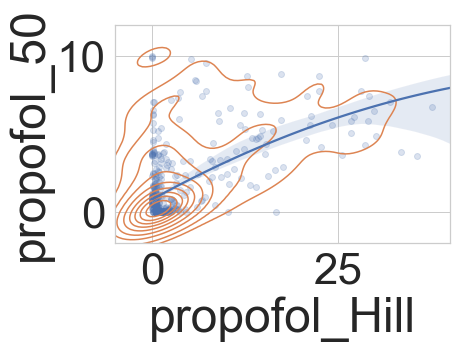

In [197]:
sns.regplot(data=pd_param_df,x='propofol_Hill',y='propofol_50',scatter_kws={'alpha':0.2},order=2)
sns.kdeplot(data=pd_param_df,x='propofol_Hill',y='propofol_50')
plt.ylim((-2,12))
plt.xlim((-5,40))

In [190]:
pd_param_df.to_csv('pd_params_lev_prop.csv')

In [7]:
np.mean(iic_burden['D'][0],axis=0)

array([ 0.        , 43.1257452 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.08840876,  0.        , 55.95103363])

In [30]:
patients = ['sid1158',
             'sid871',
             'sid708',
             'sid287',
             'sid1832',
             'sid286',
             'sid1211',
             'sid1577',
             'sid877',
             'sid320',
             'sid861',
             'sid350',
             'sid967',
             'sid1112',
             'sid351',
             'sid345',
             'sid353',
             'sid804',
             'sid958',
             'sid970',
             'sid742',
             'sid959',
             'sid949',
             'sid341',
             'sid962',
             'sid1117',
             'sid1881',
             'sid826',
             'sid1127',
             'sid1118',
             'sid1125',
             'sid1119',
             'sid1535',
             'sid834',
             'sid1486',
             'sid1109',
             'sid1532',
             'sid716',
             'sid1144',
             'sid850',
             'sid846',
             'sid1194',
             'sid922',
             'sid854',
             'sid868',
             'sid920',
             'sid855',
             'sid699']

In [42]:
idxs = pd.DataFrame(iic_burden['sids'])
idxs = idxs.reset_index()
patients_idx = idxs.set_index(0).loc[patients].values

In [40]:
D = []
for i in tqdm.tqdm(list(patients_idx.T[0])):
    D.append(np.mean(iic_burden['Ddose'][i]>0,axis=0))
    
D = pd.DataFrame(np.array(D),columns=iic_burden['Dname'])

100%|██████████| 48/48 [00:00<00:00, 19168.48it/s]


In [41]:
D.mean().sort_values()

midazolam        0.000000
pentobarbital    0.000000
valproate        0.000000
diazepam         0.000000
fosphenytoin     0.000000
lacosamide       0.000104
lorazepam        0.000225
phenobarbital    0.000317
levetiracetam    0.010274
propofol         0.622306
dtype: float64

In [44]:
patients_idx.T[0]

array([ 796,  588,  488,  183, 1215,  182,  824, 1052,  593,  208,  582,
        231,  663,  759,  232,  228,  234,  541,  658,  665,  514,  659,
        650,  225,  660,  764, 1247,  555,  774,  765,  772,  766, 1028,
        560,  997,  756, 1026,  492,  786,  573,  570,  814,  626,  577,
        586,  624,  578,  482])